In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip -V

pip 21.0.1 from /Users/JessicaJ/opt/anaconda3/lib/python3.8/site-packages/pip (python 3.8)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-contrib-python

     |████████████████████████████████| 51.3 MB 12.9 MB/s eta 0:00:01   |███                             | 4.7 MB 1.6 MB/s eta 0:00:29
Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2

In [2]:
%matplotlib inline
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import cv2
import os

In [3]:
def define_discriminator(input_shape=(32,32,3)):
    model = keras.models.Sequential()
     # Input is a 32*32*3 image
    model.add(keras.layers.Conv2D(filters=64,kernel_size= (3,3),padding = 'same',input_shape = input_shape))
    
    # The use of LeakyReLU, dropout and Adam as well as their 
    # parameters are derived from the documentation and good practices suggestions. 

    model.add(keras.layers.LeakyReLU(0.2))
    #model.add(keras.layers.Dropout(0.4))

    # Downsample 16*16*3 image
    model.add(keras.layers.Conv2D(filters= 128,kernel_size= (3,3),strides = (2,2),padding = 'same'))
    model.add(keras.layers.LeakyReLU(0.2))
    #model.add(keras.layers.Dropout(0.4))
    
    # Downsample 8*8*3 image
    model.add(keras.layers.Conv2D(filters= 128,kernel_size= (4,4),strides = (2,2),padding = 'same'))
    model.add(keras.layers.LeakyReLU(0.2))
    #model.add(keras.layers.Dropout(0.4))
    
    # Downsample 4*4*3
    model.add(keras.layers.Conv2D(filters= 256, kernel_size= (4,4), strides = (2,2), padding = 'same'))
    model.add(keras.layers.LeakyReLU(0.2))
    #model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.4))

    # We have a single node in the output layer with 
    # sigmoid activation function for the prediction (real or fake)

    model.add(keras.layers.Dense(units= 1,activation = 'sigmoid'))
    opt = keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
    model.compile(loss= 'binary_crossentropy', optimizer= opt, metrics = ['accuracy'])
    
    return model

In [4]:
# Input: Point in latent space
# Output: Rgb Image of 32 × 32 pixels (pixel values between -1 - 1)

def define_generator(latent_dim):
  # use a hidden dense layer to represent a low resolution version of the output (4 x 4 x 3).
  # Give enough nodes (256 - Arbitrary - can be changed) for multiple versions 
  # of the output image (more feature maps).
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(units= 256 * 4 * 4, input_dim = latent_dim)) #4 * 4 Arbitrary - Can be changed to test different results
    model.add(keras.layers.LeakyReLU(0.2)) # LeakyReLU with a default slope of 0.2, reported as a good practice. 
    model.add(keras.layers.Reshape((4, 4, 256)))
    # Pass the resulting feature maps into convolutional layer. 
    # Upsample the image to higher resolution.
    # Use Conv2DTranspose for upsampling with a stride of 2x2 
    # Repeat upsampling until achieving our 32 x 32 size goal.

    # Upsample 8 * 8 
    model.add(keras.layers.Conv2DTranspose(filters= 128, kernel_size = (4,4),padding='same', strides= (2,2)))
    model.add(keras.layers.LeakyReLU(0.2))
    # Upsample 16 * 16 
    model.add(keras.layers.Conv2DTranspose(filters= 128, kernel_size = (4,4),padding='same', strides= (2,2)))
    model.add(keras.layers.LeakyReLU(0.2))
    # Upsample  32 * 32 now
    model.add(keras.layers.Conv2DTranspose(filters= 128, kernel_size = (4,4),padding='same', strides= (2,2)))
    model.add(keras.layers.LeakyReLU(0.2))

    # Conv2D output layer with 3 filters (3 channels) with a kernel size of 3 
    # for generation of single feature map with preserved dimensions (32 x 32 x 3)
    # Use Than activation (good practice) to ensure the values are in range (from -1 to 1).
    model.add(keras.layers.Conv2D(filters= 3, kernel_size= (3,3),padding = 'same', activation= 'tanh')) 

    # the generated images are completely random pixel values in [-1, 1], rescaled to [0, 1].
    
    return model

In [5]:
# Discriminator is marked as not trainable (to avoid over trainning with fake samples).
def define_GAN(g_model, d_model):
    d_model.trainable = False
    model = keras.models.Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = keras.optimizers.Adam(learning_rate= 0.0002,beta_1= 0.5)
    model.compile(loss= 'binary_crossentropy', optimizer= opt)
    return model

In [6]:
#Generate Sample
def load_data():
    (X_train, _), (_, _) = keras.datasets.cifar10.load_data()
    return X_train

In [7]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    X = np.random.randn(latent_dim * n_samples) # generate points in the latent space
    X = X.reshape((n_samples, latent_dim)) # reshape into a batch of inputs for the network
    return X

In [8]:
# select real samples
def generate_real_sample(n_samples):
    data = load_data() #we are loading the data withouth labels
    ix = np.random.randint(0,data.shape[0], n_samples)
    X = data[ix] # retrieve selected random images
    X = X.reshape((n_samples, 32, 32, 3)).astype('float32')
    X = (X - 127.5) / 127.5 # scale from [0,255] to [-1,1]
    y = np.ones((n_samples, 1)) # create real class labels
    return X, y

In [9]:
# use the generator to generate n fake examples, with class labels
def generate_fake_sample(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim= latent_dim,n_samples= n_samples)  # generate points in latent space
    X = g_model.predict(x_input) # predict outputs
    y = np.zeros((n_samples, 1)) # create class labels 
    return X, y

In [10]:
#Summarize and plot
# create and save a plot of generated images
def save_plot(x_input, epoch, n=7):
    x_input = (x_input + 1.0) / 2.0
    filename = f'generated_{epoch + 1}.png'
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.imshow(x_input[i,:,:,:])
        plt.axis('off')
    plt.savefig(filename)
    plt.show()
    plt.close()
    

In [11]:
# Evaluate discriminator, plot generated images, save generator model
def summarize_the_model(g_model, d_model, epoch, latent_dim, n_samples):
    X_real, y_real = generate_real_sample(n_samples= n_samples)
    X_fake, y_fake = generate_fake_sample(g_model= g_model,
                                          latent_dim= latent_dim,
                                          n_samples= n_samples)
    print(f'Accuracy on real data: {d_model.evaluate(X_real, y_real, verbose= 0)}')
    print(f'Accuracy on fake data: {d_model.evaluate(X_fake, y_fake, verbose= 0)}')
    filename = f'model_e_{epoch + 1}.h5'
    save_plot(x_input= X_fake,
              epoch= epoch)
    
    g_model.save(filename)

In [12]:
#Model Training
# train the generator and discriminator
def train_GAN(gan_model, g_model, d_model, dataset_len, latent_dim, iters= 200, batch_size= 256):
    half_batch = int(batch_size / 2)
    batch_per_epoch = int(dataset_len / batch_size)
    for i in range(iters):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_sample(n_samples= half_batch)
            X_fake, y_fake = generate_fake_sample(g_model= g_model,
                                                  latent_dim= latent_dim,
                                                  n_samples= half_batch)
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_model.train_on_batch(X, y)
            
            x_gan = generate_latent_points(latent_dim= latent_dim,
                                             n_samples= batch_size)
            y_gan = np.ones((batch_size, 1))
            gan_model.train_on_batch(x_gan, y_gan)
            if not j%100: 
                print(f'Epoch: {i+1}, Batches/Epoch: {j+1}/{batch_per_epoch}')
                summarize_the_model(g_model= g_model,
                                    d_model= d_model,
                                    epoch= i,
                                    latent_dim= latent_dim,
                                    n_samples= batch_size)

170500096/170498071 [==============================] - 9s 0us/step
Epoch: 1, Batches/Epoch: 1/195
Accuracy on real data: [0.6093190908432007, 1.0]
Accuracy on fake data: [0.6959528923034668, 0.0]


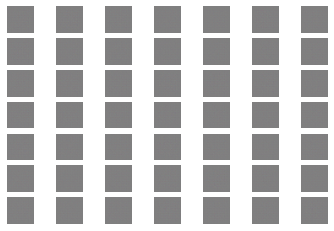

Epoch: 1, Batches/Epoch: 101/195
Accuracy on real data: [0.38358792662620544, 0.85546875]
Accuracy on fake data: [0.2898541986942291, 1.0]


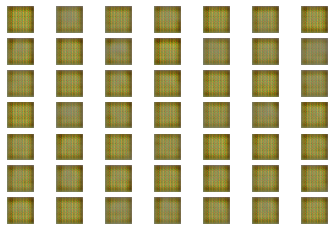

Epoch: 2, Batches/Epoch: 1/195
Accuracy on real data: [0.1852942705154419, 0.8984375]
Accuracy on fake data: [0.12343437224626541, 1.0]


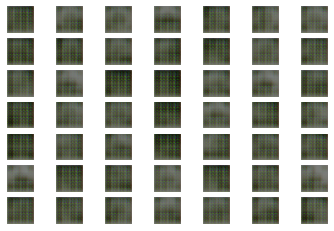

Epoch: 2, Batches/Epoch: 101/195
Accuracy on real data: [0.41430404782295227, 0.8359375]
Accuracy on fake data: [0.08967074751853943, 1.0]


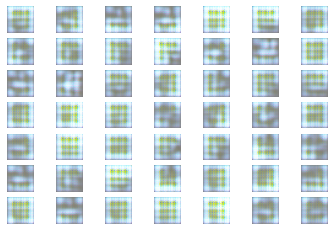

Epoch: 3, Batches/Epoch: 1/195
Accuracy on real data: [0.6760063767433167, 0.609375]
Accuracy on fake data: [0.3584485352039337, 0.97265625]


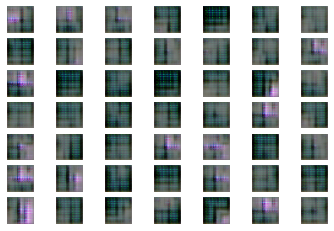

Epoch: 3, Batches/Epoch: 101/195
Accuracy on real data: [0.9763861894607544, 0.49609375]
Accuracy on fake data: [0.35072869062423706, 0.87890625]


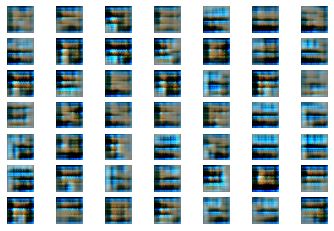

Epoch: 4, Batches/Epoch: 1/195
Accuracy on real data: [0.5777285695075989, 0.62890625]
Accuracy on fake data: [0.6192854642868042, 0.69140625]


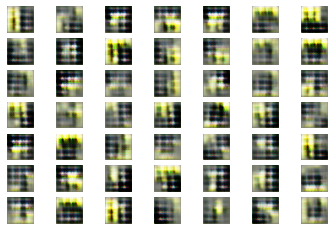

Epoch: 4, Batches/Epoch: 101/195
Accuracy on real data: [0.8076183795928955, 0.61328125]
Accuracy on fake data: [0.2659291625022888, 0.93359375]


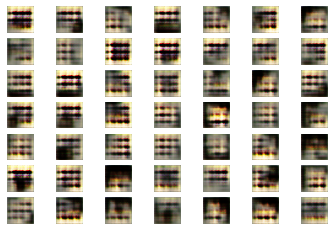

Epoch: 5, Batches/Epoch: 1/195
Accuracy on real data: [0.5310096144676208, 0.7109375]
Accuracy on fake data: [0.2702116370201111, 0.99609375]


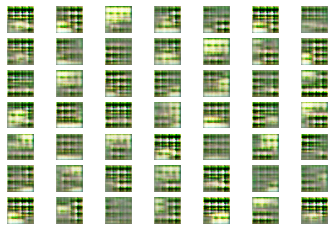

Epoch: 5, Batches/Epoch: 101/195
Accuracy on real data: [0.39900484681129456, 0.82421875]
Accuracy on fake data: [0.246473491191864, 0.99609375]


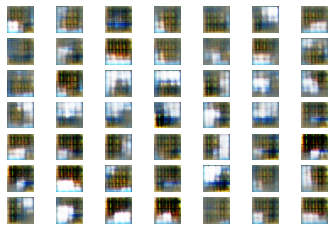

Epoch: 6, Batches/Epoch: 1/195
Accuracy on real data: [0.3394358158111572, 0.92578125]
Accuracy on fake data: [0.48313143849372864, 0.76953125]


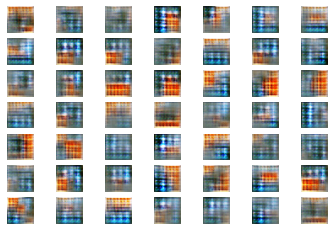

Epoch: 6, Batches/Epoch: 101/195
Accuracy on real data: [0.40572497248649597, 0.8046875]
Accuracy on fake data: [0.3045554757118225, 0.984375]


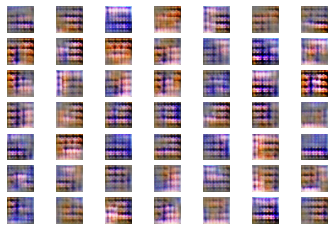

Epoch: 7, Batches/Epoch: 1/195
Accuracy on real data: [0.5791479349136353, 0.69921875]
Accuracy on fake data: [0.5175214409828186, 0.8046875]


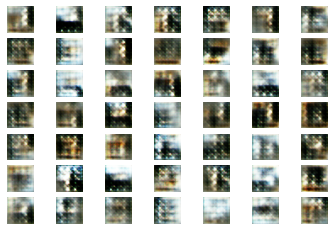

Epoch: 7, Batches/Epoch: 101/195
Accuracy on real data: [0.5627931356430054, 0.73046875]
Accuracy on fake data: [0.6019346117973328, 0.6640625]


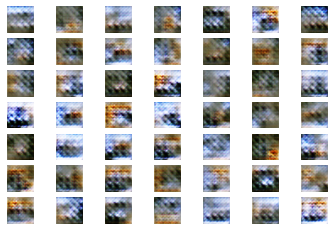

Epoch: 8, Batches/Epoch: 1/195
Accuracy on real data: [0.48114803433418274, 0.76953125]
Accuracy on fake data: [0.47169366478919983, 0.828125]


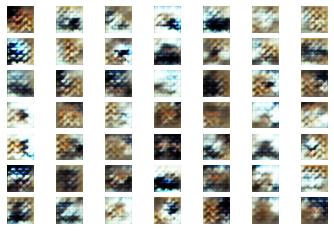

Epoch: 8, Batches/Epoch: 101/195
Accuracy on real data: [0.6229724884033203, 0.61328125]
Accuracy on fake data: [0.5926647782325745, 0.69140625]


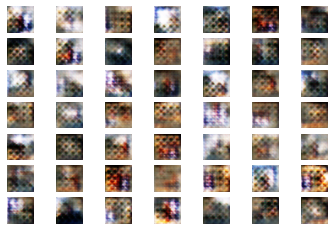

Epoch: 9, Batches/Epoch: 1/195
Accuracy on real data: [0.544015645980835, 0.7265625]
Accuracy on fake data: [0.5329777002334595, 0.80078125]


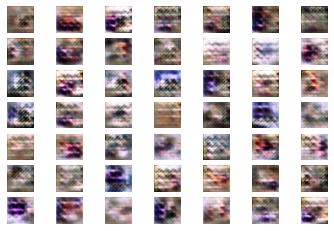

Epoch: 9, Batches/Epoch: 101/195
Accuracy on real data: [0.6223955154418945, 0.64453125]
Accuracy on fake data: [0.433002769947052, 0.9140625]


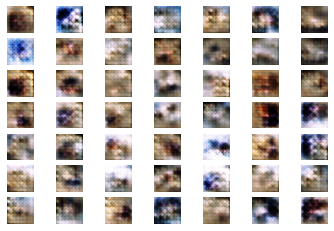

Epoch: 10, Batches/Epoch: 1/195
Accuracy on real data: [0.9659008979797363, 0.3125]
Accuracy on fake data: [0.41150596737861633, 0.90625]


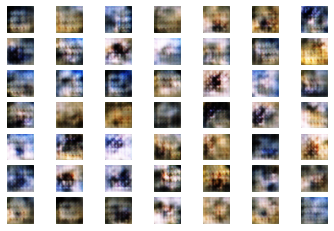

Epoch: 10, Batches/Epoch: 101/195
Accuracy on real data: [0.6013699769973755, 0.66015625]
Accuracy on fake data: [0.4282364845275879, 0.9375]


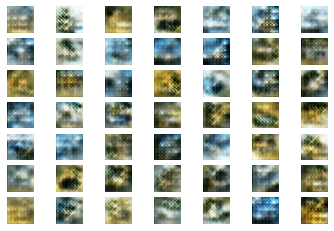

Epoch: 11, Batches/Epoch: 1/195
Accuracy on real data: [0.4246012568473816, 0.85546875]
Accuracy on fake data: [0.5114724040031433, 0.87109375]


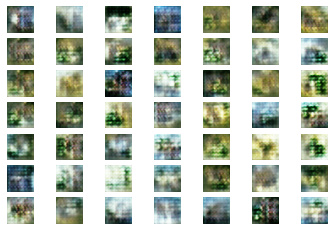

Epoch: 11, Batches/Epoch: 101/195
Accuracy on real data: [0.41179218888282776, 0.81640625]
Accuracy on fake data: [0.44148585200309753, 0.8203125]


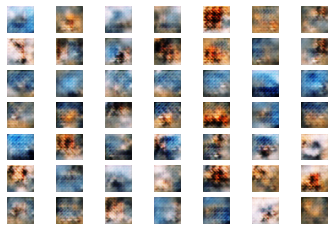

Epoch: 12, Batches/Epoch: 1/195
Accuracy on real data: [1.3089191913604736, 0.1796875]
Accuracy on fake data: [0.18287208676338196, 0.97265625]


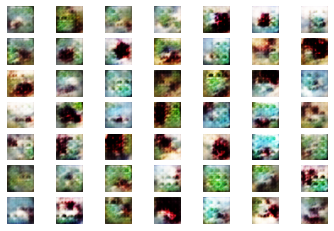

Epoch: 12, Batches/Epoch: 101/195
Accuracy on real data: [0.28905022144317627, 0.875]
Accuracy on fake data: [0.9423742294311523, 0.390625]


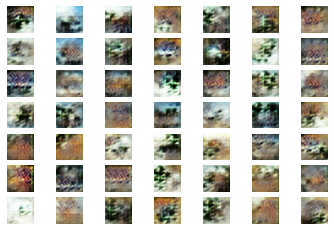

Epoch: 13, Batches/Epoch: 1/195
Accuracy on real data: [0.37210389971733093, 0.8671875]
Accuracy on fake data: [0.4340451955795288, 0.90625]


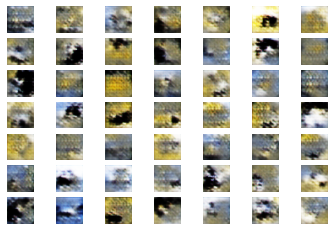

Epoch: 13, Batches/Epoch: 101/195
Accuracy on real data: [0.5757402181625366, 0.6796875]
Accuracy on fake data: [0.42426857352256775, 0.92578125]


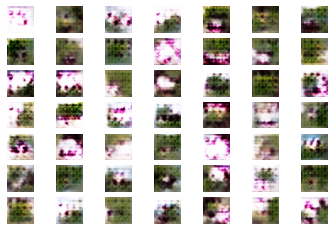

Epoch: 14, Batches/Epoch: 1/195
Accuracy on real data: [0.6344556212425232, 0.640625]
Accuracy on fake data: [0.4812430739402771, 0.78515625]


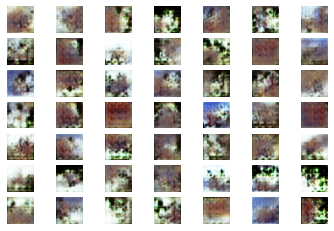

Epoch: 14, Batches/Epoch: 101/195
Accuracy on real data: [0.49000298976898193, 0.70703125]
Accuracy on fake data: [0.3653002083301544, 0.94921875]


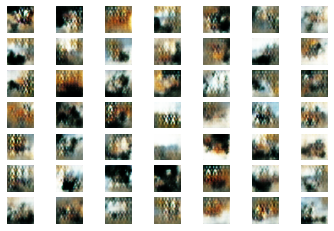

Epoch: 15, Batches/Epoch: 1/195
Accuracy on real data: [0.4027886390686035, 0.78515625]
Accuracy on fake data: [0.5164527893066406, 0.80859375]


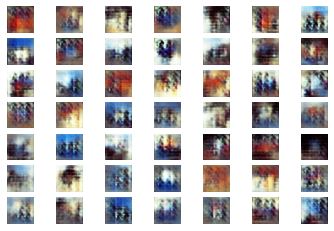

Epoch: 15, Batches/Epoch: 101/195
Accuracy on real data: [0.6042228937149048, 0.640625]
Accuracy on fake data: [0.6000704765319824, 0.69140625]


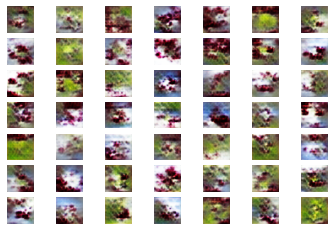

Epoch: 16, Batches/Epoch: 1/195
Accuracy on real data: [0.5583848357200623, 0.66796875]
Accuracy on fake data: [0.4139854907989502, 0.85546875]


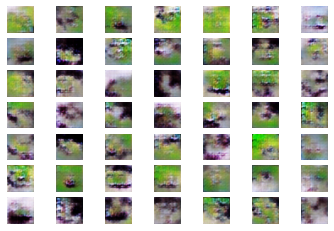

Epoch: 16, Batches/Epoch: 101/195
Accuracy on real data: [0.5171305537223816, 0.69140625]
Accuracy on fake data: [0.5236545205116272, 0.76171875]


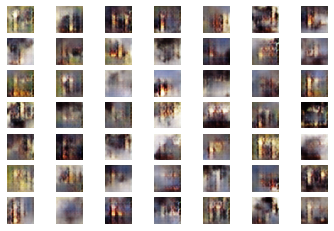

Epoch: 17, Batches/Epoch: 1/195
Accuracy on real data: [0.36665573716163635, 0.84375]
Accuracy on fake data: [0.4197813868522644, 0.890625]


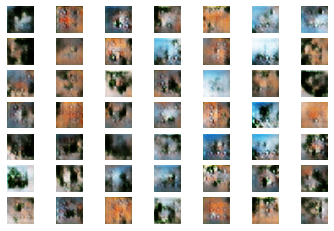

Epoch: 17, Batches/Epoch: 101/195
Accuracy on real data: [0.4088857173919678, 0.796875]
Accuracy on fake data: [0.541196346282959, 0.8203125]


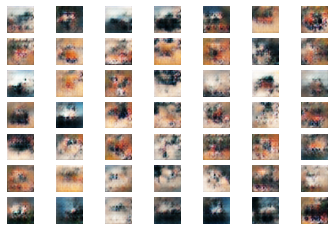

Epoch: 18, Batches/Epoch: 1/195
Accuracy on real data: [0.6904118061065674, 0.5546875]
Accuracy on fake data: [0.5294948220252991, 0.77734375]


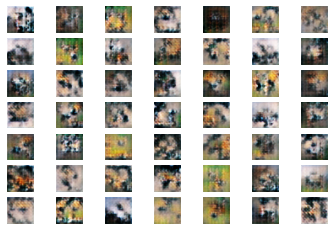

Epoch: 18, Batches/Epoch: 101/195
Accuracy on real data: [0.44759148359298706, 0.75]
Accuracy on fake data: [0.4469035267829895, 0.90625]


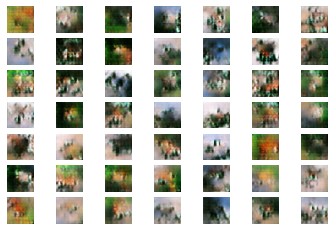

Epoch: 19, Batches/Epoch: 1/195
Accuracy on real data: [0.5001363158226013, 0.6875]
Accuracy on fake data: [0.5211474895477295, 0.78515625]


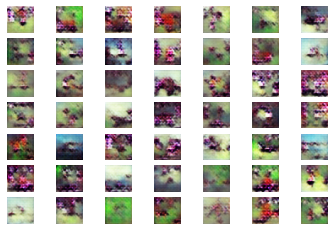

Epoch: 19, Batches/Epoch: 101/195
Accuracy on real data: [0.59126877784729, 0.61328125]
Accuracy on fake data: [0.4384860396385193, 0.8828125]


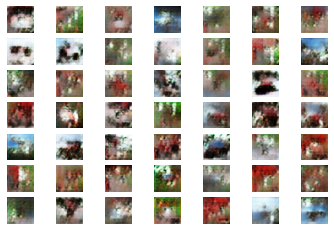

Epoch: 20, Batches/Epoch: 1/195
Accuracy on real data: [0.7240622043609619, 0.52734375]
Accuracy on fake data: [0.40452873706817627, 0.89453125]


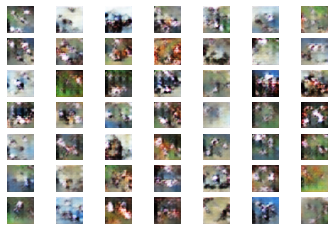

Epoch: 20, Batches/Epoch: 101/195
Accuracy on real data: [0.6390696167945862, 0.6015625]
Accuracy on fake data: [0.4866301119327545, 0.8203125]


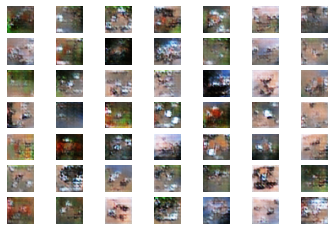

Epoch: 21, Batches/Epoch: 1/195
Accuracy on real data: [0.31087183952331543, 0.875]
Accuracy on fake data: [0.6332318186759949, 0.62109375]


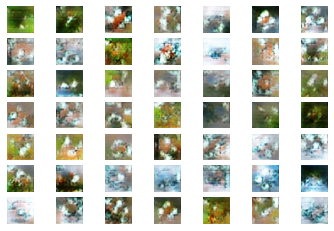

Epoch: 21, Batches/Epoch: 101/195
Accuracy on real data: [0.7661105990409851, 0.4296875]
Accuracy on fake data: [0.35226717591285706, 0.97265625]


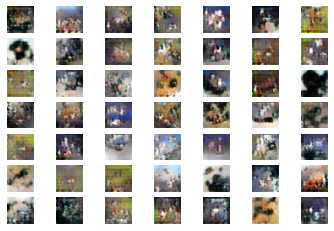

Epoch: 22, Batches/Epoch: 1/195
Accuracy on real data: [0.6153799295425415, 0.54296875]
Accuracy on fake data: [0.4207598567008972, 0.9296875]


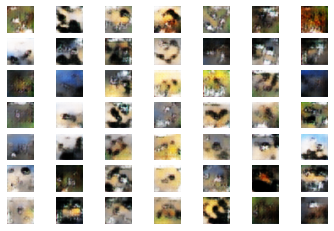

Epoch: 22, Batches/Epoch: 101/195
Accuracy on real data: [0.5524016618728638, 0.65234375]
Accuracy on fake data: [0.5017534494400024, 0.83984375]


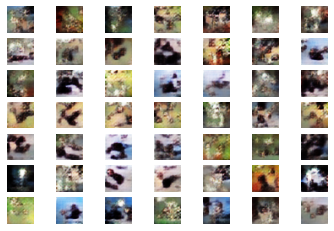

Epoch: 23, Batches/Epoch: 1/195
Accuracy on real data: [0.5315560102462769, 0.65625]
Accuracy on fake data: [0.4340074360370636, 0.8828125]


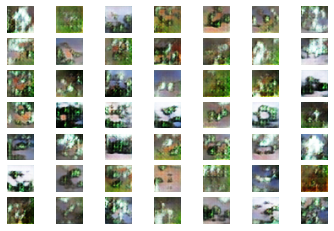

Epoch: 23, Batches/Epoch: 101/195
Accuracy on real data: [0.5254570841789246, 0.6015625]
Accuracy on fake data: [0.6358108520507812, 0.73828125]


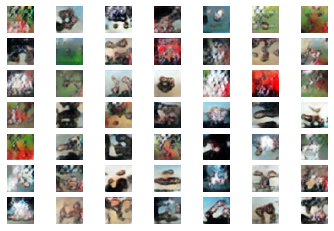

KeyboardInterrupt: 

In [13]:
# size of the latent space
latent_dim = 100
g_model = define_generator(latent_dim= latent_dim) 
d_model = define_discriminator()
gan_model = define_GAN(d_model= d_model,
                       g_model= g_model)
train_GAN(gan_model= gan_model, 
          g_model= g_model,
          d_model= d_model,
          dataset_len= load_data().shape[0],
          latent_dim= latent_dim)

In [ ]:
#prediction on resulting model
# Load pretrained model 
model = keras.models.load_model('./model_e_99.h5', compile= False)

In [ ]:
# Plot pre trained model prediction
vec = np.array([[np.cos(_) for _ in range(100)]])
X = ( model.predict(vec) + 1 ) / 2.0
plt.imshow(X[0])
plt.show()

In [ ]:
# Define plotting for 49 image sample
def plotModel(model, n_samples=49):
    plt.figure(figsize=(18,9))
    for i in range(n_samples):
        ran = np.random.randn(n_samples, 100)
        sqrt = int(np.sqrt(n_samples))
        plt.subplot(sqrt, sqrt, i+1)
        X = model.predict(ran)
        X = (X + 1) / 2.0
        plt.imshow(X[0])
        plt.axis('off')
    plt.show()

In [ ]:
plotModel(model, n_samples= 25)